<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Загрузка-и-подготовка-данных" data-toc-modified-id="1.-Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Загрузка и подготовка данных</a></span></li><li><span><a href="#2.-Обучение-моделей" data-toc-modified-id="2.-Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Обучение моделей</a></span></li><li><span><a href="#3.-Выводы" data-toc-modified-id="3.-Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект текстовой классификации

Интернет-магазин запускает новый сервис. Пользователи смогут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель для классификации комментариев на позитивные и негативные. 

Основной критерий качества модели - значение метрики качества *F1* не меньше 0.75. 

**План работ:**

1. Загрузка и подготовка данных.
2. Обучение моделей. 
3. Выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Загрузка и подготовка данных

In [1]:
import re
import os
import sys
import csv
import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
import string
import warnings
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, RidgeClassifier

from sklearn.model_selection import (GridSearchCV,
                                     cross_validate, 
                                     KFold,
                                     train_test_split)

from numpy.random import RandomState


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/andrew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

In [3]:
print("Number of rows in data =",df.shape[0])
print("Number of columns in data =",df.shape[1])
print('Number of duplicates:', df.duplicated().sum())
print('Number of NA values:', df.isna().sum())
df.sample(5)

Number of rows in data = 159292
Number of columns in data = 3
Number of duplicates: 0
Number of NA values: Unnamed: 0    0
text          0
toxic         0
dtype: int64


,Unnamed: 0,text,toxic
102027,102124,""":::As someone from a family who fought there ...",0
18421,18440,I appreciate your feedback. Please read my us...,0
36535,36577,"I see. Now that the article is locked, articl...",0
22056,22076,I don't think he is the best choice.,0
156963,157122,Re: Warning \n\n>>Stop hand nuvola.svg This is...,1


[Text(0.5, 1.0, 'Распределение комментариев')]

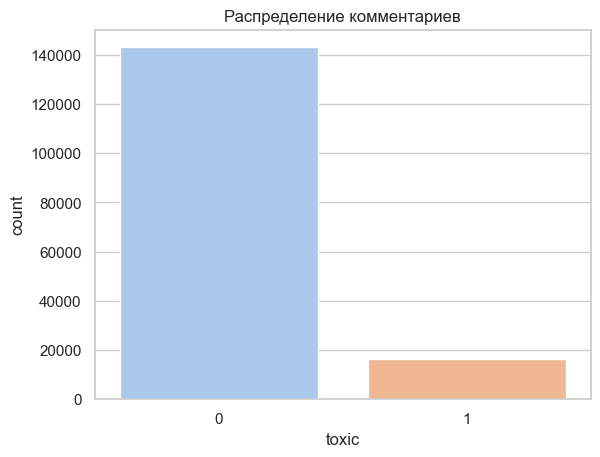

In [4]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(x = 'toxic', data = df).set(title='Распределение комментариев')

На графике наглядно видим дисбаланс классов, необходимо будет учесть данную особенность при построении моделей - class_weight :'balanced'

В нашем случае дисбалнс классов не вызывает особых подозрений и не ставит под сомнение корректность исходных данных, так как в реальной жизни "токсичные" комментарии встречаются не так часто. 

In [5]:
data = df
if not sys.warnoptions:
    warnings.simplefilter("ignore")


def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['punct'] = data['text'].apply(lambda x: remove_punct(x))
data.sample(2)

,Unnamed: 0,text,toxic,punct
52596,52653,Or what your gonna ban my IP? What a joke... D...,1,Or what your gonna ban my IP What a joke Dumb ass
150666,150822,Prithviraj III grave?! \n\nWhere is it?! take ...,0,Prithviraj III grave \n\nWhere is it take a ph...


In [6]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

data['tokenized'] = data['punct'].apply(lambda x: tokenization(x.lower()))
data.sample(2)

,Unnamed: 0,text,toxic,punct,tokenized
37187,37229,"""\n\nWHEN THIS USER GETS REPORTED??? ohh man.....",1,\n\nWHEN THIS USER GETS REPORTED ohh man you p...,"[, when, this, user, gets, reported, ohh, man,..."
47848,47903,listen 2 me \n\nU hippocrite (alas it is ur na...,0,listen me \n\nU hippocrite alas it is ur name...,"[listen, me, u, hippocrite, alas, it, is, ur, ..."


In [7]:
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
data['nonstop'] = data['tokenized'].apply(lambda x: remove_stopwords(x))
data.sample(2)

,Unnamed: 0,text,toxic,punct,tokenized,nonstop
46441,46496,The Internet Beatles Album,0,The Internet Beatles Album,"[the, internet, beatles, album]","[internet, beatles, album]"
83607,83686,"Actually, it appears that you were dumbfounded...",0,Actually it appears that you were dumbfoundeds...,"[actually, it, appears, that, you, were, dumbf...","[actually, appears, dumbfoundedso, decided, la..."


In [8]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

data['lemmatized'] = data['nonstop'].apply(lambda x: lemmatizer(x))
data.sample(2)

,Unnamed: 0,text,toxic,punct,tokenized,nonstop,lemmatized
44810,44863,"""\n""""Actually, Jarlaxle is right; that shit wa...",1,\nActually Jarlaxle is right that shit was don...,"[, actually, jarlaxle, is, right, that, shit, ...","[, actually, jarlaxle, right, shit, done, alex...","[, actually, jarlaxle, right, shit, done, alex..."
76027,76103,"""\n\nRegarding edits made during February 28 2...",0,\n\nRegarding edits made during February to ...,"[, regarding, edits, made, during, february, t...","[, regarding, edits, made, february, internati...","[, regarding, edits, made, february, internati..."


## 2. Обучение моделей

In [9]:
#Разделим нашу таблилцу на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=.30, random_state=12345)

In [10]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
X = train['lemmatized'].astype('str')
y = train['toxic']
X_test = test['lemmatized'].astype('str')
y_test = test['toxic']

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                             lowercase=False, 
                             max_features=None, 
                             max_df=.3, 
                             sublinear_tf=True, 
                             smooth_idf=False)

In [33]:
state = RandomState(12345)

pipe = Pipeline(steps=[('vectorizer', vectorizer),    
                       ('model', "Подберем оптимальную модель")
                       ])

params = [
    {
        'model': [RidgeClassifier(random_state=state)],
        'model__class_weight':['balanced', None],
        'model__alpha': [1.2],
    },
    {
        'model': [LogisticRegression()],
        'model__class_weight':['balanced', None],
        'model__max_iter':[1000],
        'model__C':[1,10,100]
    }, 
    {
        'model': [Lasso(random_state=state)],
        'model__alpha': np.logspace(-3, 1, 3)
    }
]

In [34]:
#Kfold = 5 считается 67минут - если нужно проверить работоспособность то 2 фолда - 10 минут) 

score = 'f1'

cv = KFold(n_splits=2, shuffle=False)
model = GridSearchCV(pipe, param_grid=params, cv = cv, n_jobs = -1, verbose=0, scoring=score)

In [35]:
model.fit(X, y)

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        max_df=0.3,
                                                        ngram_range=(1, 2),
                                                        smooth_idf=False,
                                                        sublinear_tf=True)),
                                       ('model',
                                        'Подберем оптимальную модель')]),
             n_jobs=-1,
             param_grid=[{'model': [RidgeClassifier(random_state=RandomState(MT19937) at 0x28C7D5340)],
                          'model__alpha': [1.2],
                          'model__class_weight': ['balanced', None]},
                         {'model': [LogisticRegression(C=100,
                                                       class_weight='balanced',
                                                       max_iter=1000)],
                          'model__C': [1, 10, 100],
                          'model__class_weight': ['balanced', None],
                          'model__max_iter': [1000]},
                         {'model': [Lasso(random_state=RandomState(MT19937) at 0x28C7D5340)],
                          'model__alpha': array([1.e-03, 1.e-01, 1.e+01])}],
             scoring='f1')

In [36]:
print('Лучшие параметры GridSearch:', model.best_params_)
print('Лучший F1:', model.best_score_) 

Лучшие параметры GridSearch: {'model': LogisticRegression(C=100, class_weight='balanced', max_iter=1000), 'model__C': 100, 'model__class_weight': 'balanced', 'model__max_iter': 1000}
Лучший F1: 0.7797685847655189


## 3. Выводы

In [37]:
predictions = model.predict(X_test)
print('F1 pred:', f1_score(y_test, predictions).round(3))

F1 pred: 0.8


[Text(0.5, 1.0, 'Распределение комментариев в предсказаниях модели')]

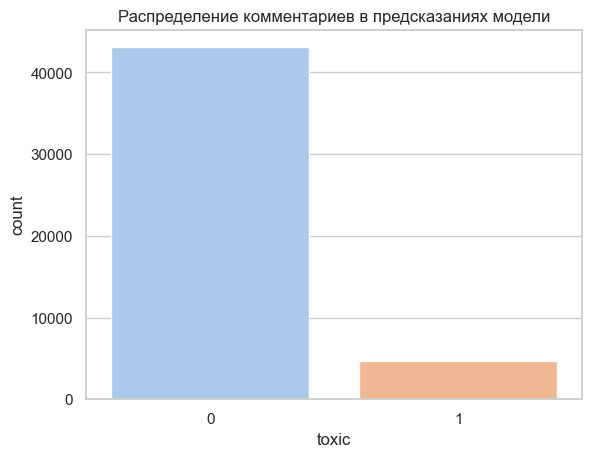

In [19]:
#Для проверки на адекватность - построим также аналогичный график для предсказаний модели. 
pred = pd.DataFrame(predictions, columns=['toxic'])

sns.countplot(x = 'toxic', data = pred).set(title='Распределение комментариев в предсказаниях модели')

В ходе работы над проектом мы загрузили файл с комментариями пользователей, который содержал ***159 тыс*** записей. 

На стадии подготовки данных мы последовательно подготовили файл для обучения моделей.

С помощью ***Gridsearch CV*** мы проанализировали 3 модели: ***RidgeClassifier, LogisticRegression и Lasso.*** 

Наилучший результат с учетом всех преобразований показала модель ***LogisticRegression*** с результатом метрики ***F1 0,78*** на обучающей выборке после кросс валидации, и ***0,8*** на тестовой. 